In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('./src')

In [3]:
df = pd.read_csv('ETTh1.csv', index_col=0)

In [4]:
df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [5]:
LOOKBACK = 336      # L: Lookback window
HORIZON = 96        # T: Predict next steps
PATCH_DIM = 32      # P: Patch size
STRIDE = 16          # S: Distance between start of subsequent patches
EMBED_DIM = 64      # D: Embedding dimensionality

NUM_HEADS = 4        # Number of attention heads in the transformer encoder

# As suggested by the paper
NUM_PATCHES = (LOOKBACK - PATCH_DIM) // STRIDE + 2

In [6]:
from src.dataset import ETTh1

train_dataset = ETTh1(file_path='./ETTh1.csv', split='train', lookback=LOOKBACK, horizon=HORIZON)
test_dataset = ETTh1(file_path='./ETTh1.csv', split='test', lookback=LOOKBACK, horizon=HORIZON)
val_dataset = ETTh1(file_path='./ETTh1.csv', split='val', lookback=LOOKBACK, horizon=HORIZON)

In [7]:
sample = train_dataset[0]

sample['input'].shape, sample['target'].shape, sample['mean'], sample['std']

(torch.Size([7, 336]),
 torch.Size([7, 96]),
 tensor([10.4205,  4.1493,  7.0688,  1.9808,  3.2542,  1.5870, 29.7522]),
 tensor([2.6008, 1.3502, 2.2996, 0.9182, 0.7513, 0.3647, 4.9668]))

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
import torch

torch.cuda.is_available()

True

In [23]:
from src.patch_tst import PatchTST

model = PatchTST(
    num_patches=NUM_PATCHES, 
    patch_dim=PATCH_DIM, 
    embed_dim=EMBED_DIM, 
    horizon=HORIZON,
    stride=STRIDE,
    num_heads=NUM_HEADS,
    )

In [24]:
from torch.optim import Adam

optimizer = Adam(params=model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.5, 
#     patience=3
#     )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=25,  # Number of epochs to restart after
    eta_min=1e-5  # Minimum learning rate
)

## Training

In [25]:
from src.train import TrainConfig, Trainer

config = TrainConfig(
    epochs=25,
    learning_rate=1e-4,
    batch_size=32,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    checkpoint_dir='./checkpoints/exp_003',
    save_every=2,  # Save checkpoint every 2 epochs
    early_stopping_patience=5  # Stop if no improvement for 5 epochs
)

# Create the trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    config=config,
    scheduler=scheduler 
)

# Avvia il training
history = trainer.train()

# Resume from checkpoint:
# trainer.resume_from_checkpoint('latest.pth')
# history = trainer.train()

Starting training on cuda
Configuration: {'epochs': 25, 'learning_rate': 0.0001, 'batch_size': 32, 'device': 'cuda', 'checkpoint_dir': './checkpoints/exp_003', 'save_every': 2, 'early_stopping_patience': 5}
Checkpoints will be saved to: ./checkpoints/exp_003


Epoch 1/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 40.66it/s, loss=0.6476]



Epoch 1 Summary:
  Train Loss: 1.1303
  Test Loss:  0.8867
  New best model saved! Test Loss: 0.8867

Epoch 2/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 39.65it/s, loss=0.6496]



Epoch 2 Summary:
  Train Loss: 1.0388
  Test Loss:  0.8777
  Checkpoint saved: checkpoint_epoch_2.pth
  New best model saved! Test Loss: 0.8777

Epoch 3/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 39.65it/s, loss=0.5576]



Epoch 3 Summary:
  Train Loss: 0.9958
  Test Loss:  0.8939

Epoch 4/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 36.78it/s, loss=0.5168]



Epoch 4 Summary:
  Train Loss: 0.9454
  Test Loss:  0.9392
  Checkpoint saved: checkpoint_epoch_4.pth

Epoch 5/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 38.59it/s, loss=0.6001]



Epoch 5 Summary:
  Train Loss: 0.8880
  Test Loss:  0.9047

Epoch 6/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 40.13it/s, loss=1.3242]



Epoch 6 Summary:
  Train Loss: 0.8128
  Test Loss:  1.0991
  Checkpoint saved: checkpoint_epoch_6.pth

Epoch 7/25
--------------------------------------------------


Testing: 100%|██████████| 96/96 [00:02<00:00, 38.41it/s, loss=0.7790]


Epoch 7 Summary:
  Train Loss: 0.7405
  Test Loss:  1.0655

Early stopping triggered after 7 epochs
No improvement for 5 epochs

Training completed!
Best test loss: 0.8777
Checkpoints saved in: ./checkpoints/exp_003
Training history saved to: history.json


# Plot loss history

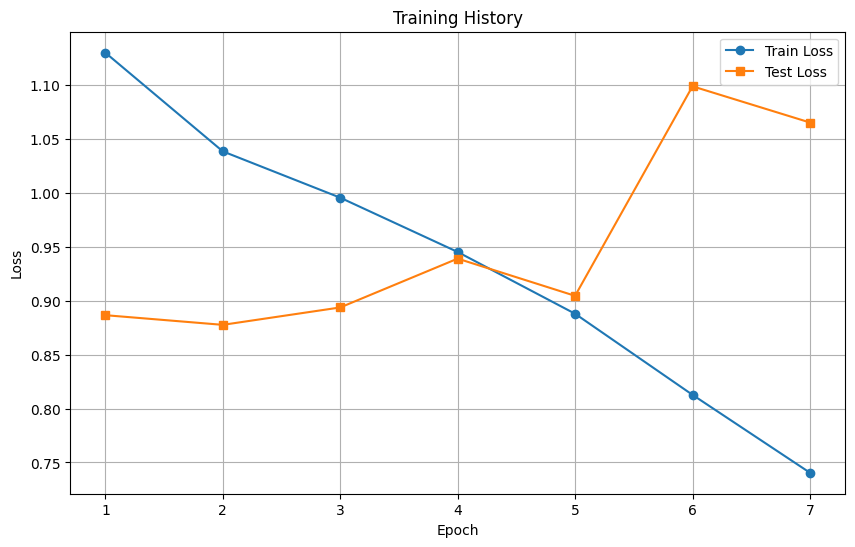

Best test loss: 0.8777
Final train loss: 0.7405
Final test loss: 1.0655


In [26]:

plt.figure(figsize=(10, 6))
plt.plot(history['epochs'], history['train_loss'], label='Train Loss', marker='o')
plt.plot(history['epochs'], history['test_loss'], label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best test loss: {min(history['test_loss']):.4f}")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final test loss: {history['test_loss'][-1]:.4f}")

### Load best model for evalutation

In [27]:
from src.checkpoint import Checkpoint

# Load best il best model
result = Checkpoint.load(
    checkpoint_path='./checkpoints/exp_003',
    checkpoint_name='best_model.pth',
    model=model
)

print(f"Loaded model from epoch {result['epoch']}")
print(f"Train loss: {result['train_loss']:.4f}")
print(f"Test loss: {result['test_loss']:.4f}")

# Model evaluation
model.eval()

Loaded model from epoch 2
Train loss: 1.0388
Test loss: 0.8777


PatchTST(
  (patching): Patching()
  (patch_embedding): PatchEmbedding(
    (linear): Linear(in_features=32, out_features=64, bias=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_head): Linear(in_features=1344, out_features=96, bias=True)
)

In [28]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
val_loss = 0
for batch in val_loader:
    input = batch['input'].to(DEVICE)
    target = batch['target'].to(DEVICE)
    mean = batch['mean'].to(DEVICE)
    std = batch['std'].to(DEVICE)

    pred = model(input)
    
    # Add dimension for broadcasting: (batch, features) -> (batch, features, 1)
    pred = pred * std.unsqueeze(-1) + mean.unsqueeze(-1)
    target = target * std.unsqueeze(-1) + mean.unsqueeze(-1)
    loss = torch.nn.functional.mse_loss(pred, target)
    val_loss += loss.item()
    # print(f'Validation Loss: {loss.item():.4f}')

avg_val_loss = val_loss / len(val_loader)
print(f'Average Validation Loss: {avg_val_loss:.4f}')


Average Validation Loss: 8.9404


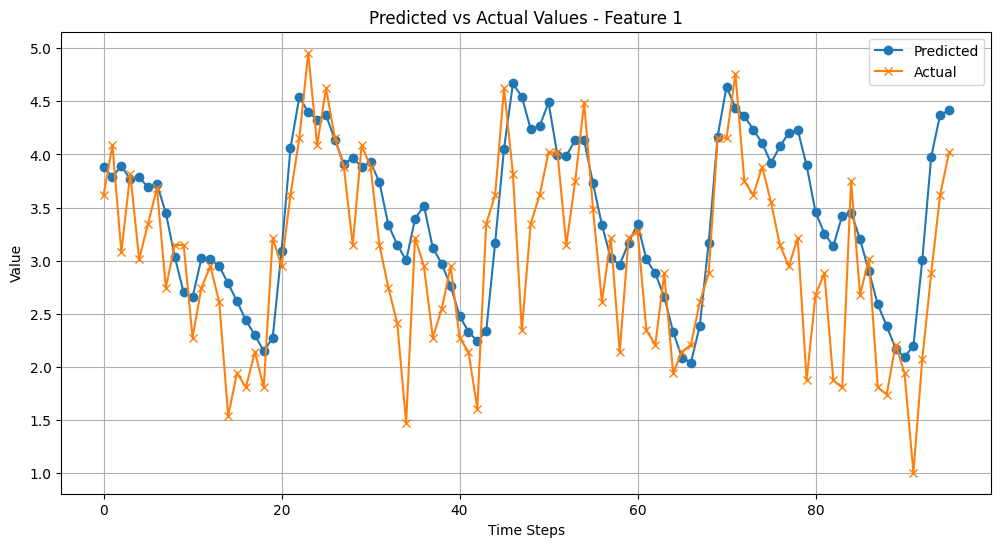

In [30]:
idx = 0
feature_idx = 1

model.eval()

input = val_dataset[idx]['input'].unsqueeze(0).to(DEVICE)
target = val_dataset[idx]['target'].unsqueeze(0).to(DEVICE)
mean = val_dataset[idx]['mean'].to(DEVICE).unsqueeze(-1)
std = val_dataset[idx]['std'].to(DEVICE).unsqueeze(-1)
with torch.no_grad():
    pred = model(input)

# Denormalize
pred = pred * std + mean
target = target * std + mean

# Convert to numpy and select single feature
pred = pred.cpu().squeeze(0).numpy()  # Shape: (features, horizon)
target = target.cpu().squeeze(0).numpy()  # Shape: (features, horizon)

# Plot single feature
plt.figure(figsize=(12, 6))
plt.plot(pred[feature_idx], label='Predicted', marker='o')
plt.plot(target[feature_idx], label='Actual', marker='x')
plt.title(f'Predicted vs Actual Values - Feature {feature_idx}')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


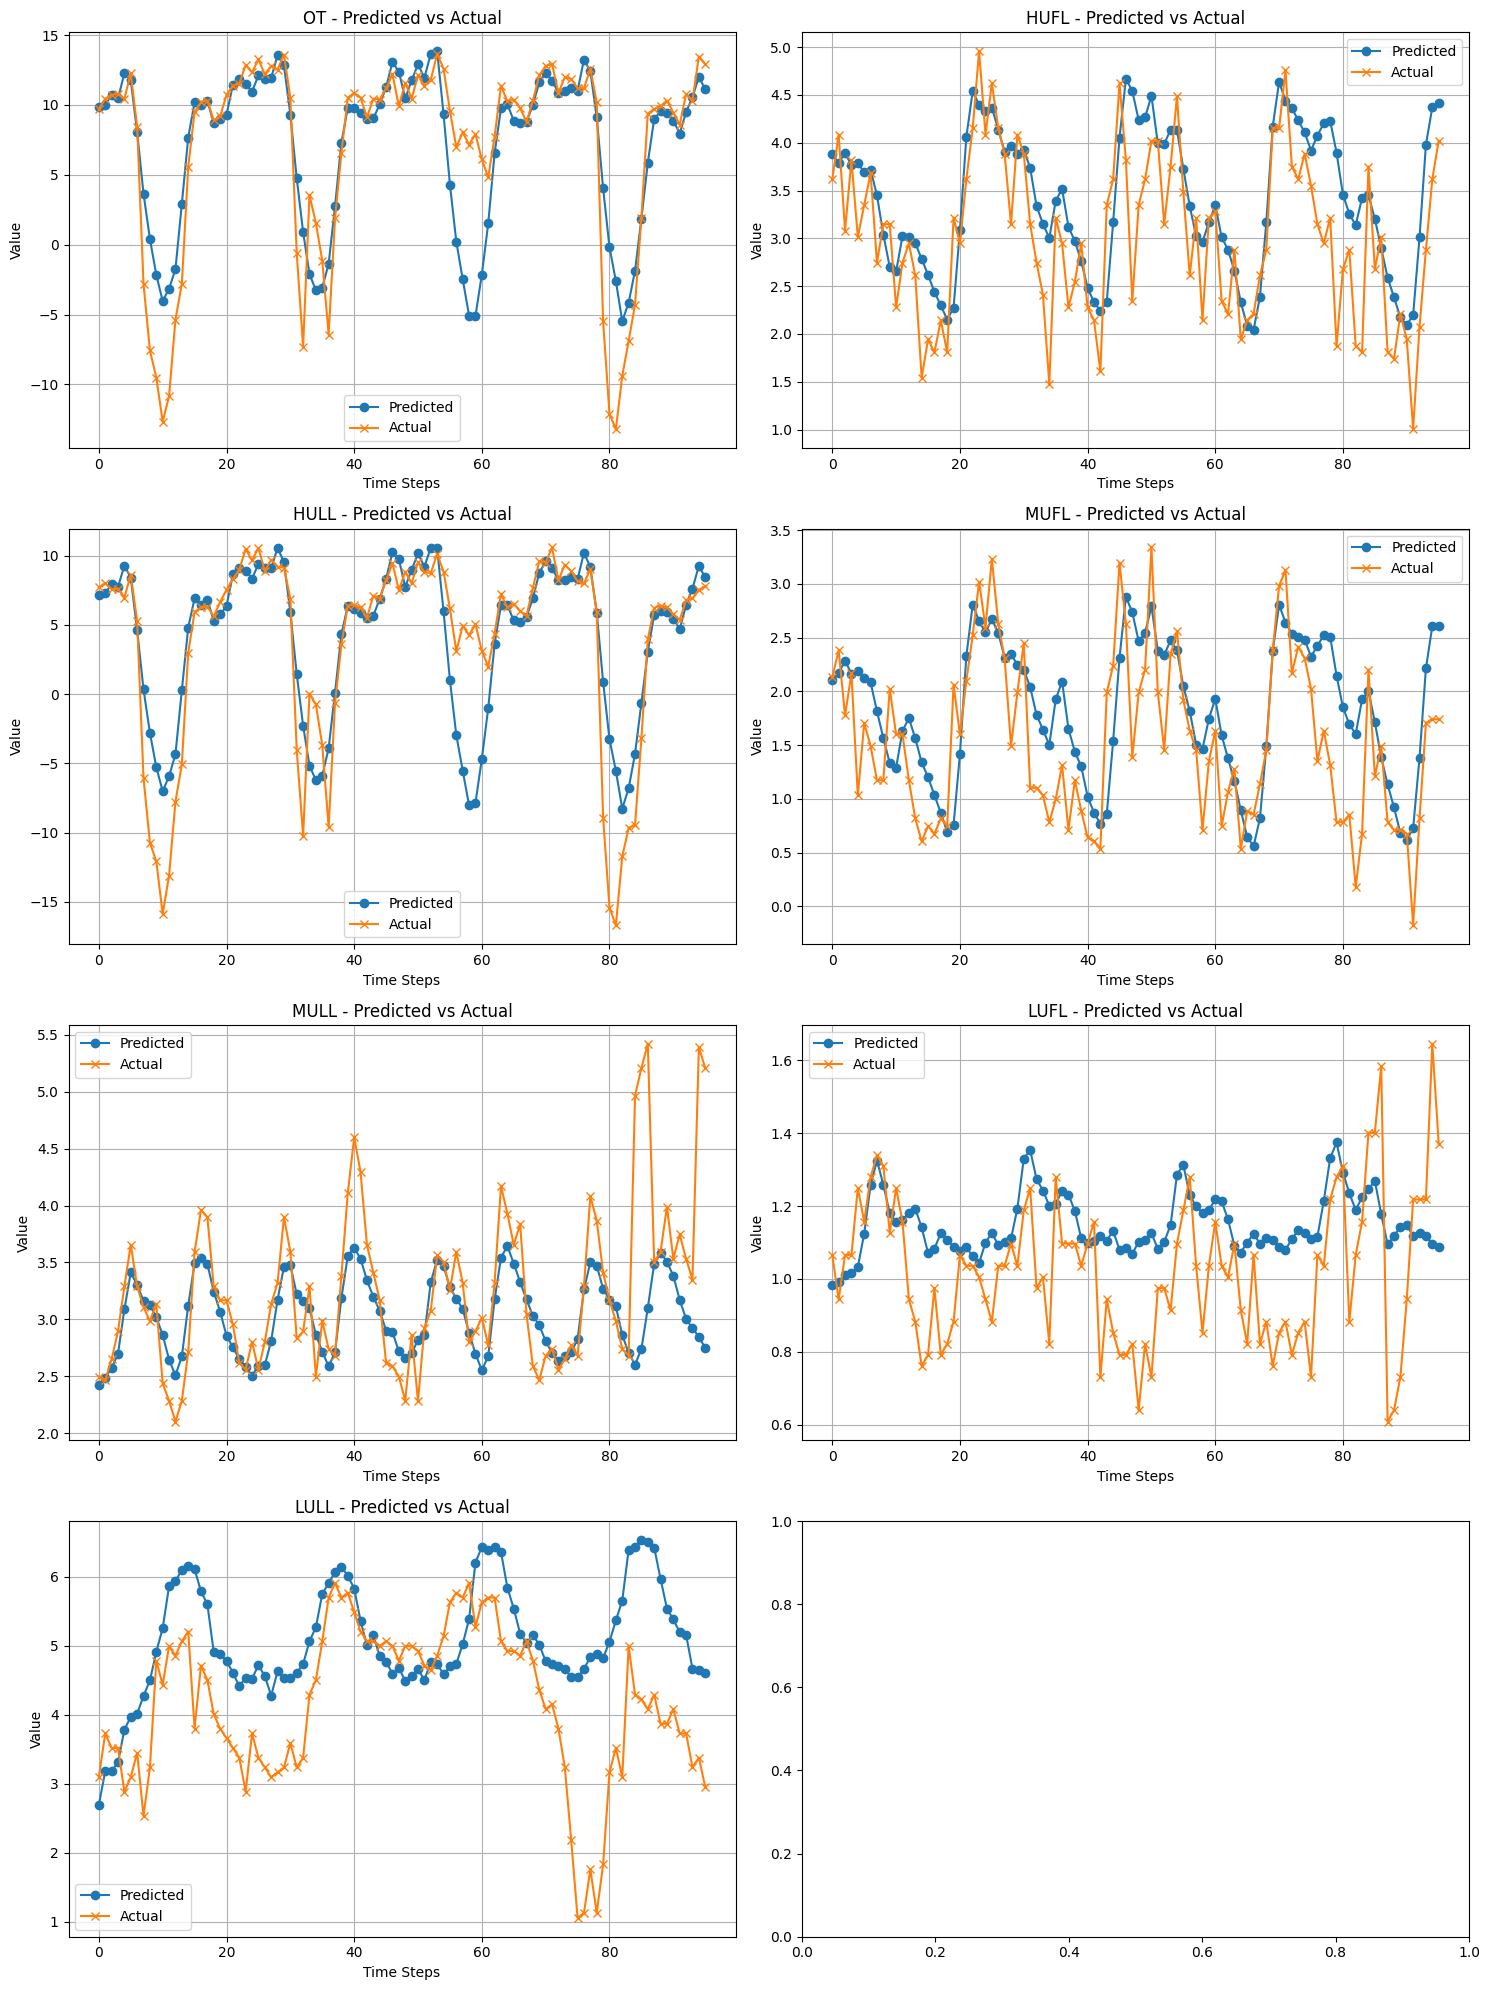

In [31]:
plt.subplots(4, 2, figsize=(15, 20))

features = ['OT', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OTHR']

for feature_idx in range(pred.shape[0]):
    plt.subplot(4, 2, feature_idx + 1)
    plt.plot(pred[feature_idx], label='Predicted', marker='o')
    plt.plot(target[feature_idx], label='Actual', marker='x')
    plt.title(f'{features[feature_idx]} - Predicted vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.savefig('pred_vs_actual.png')
plt.show()